ku80_37c (1).jpg -> N=112  germinated=48  overlay=ku80_37c (1)_overlay.png
ku80_37c (2).jpg -> N=76  germinated=27  overlay=ku80_37c (2)_overlay.png
ku80_37c (3).jpg -> N=81  germinated=31  overlay=ku80_37c (3)_overlay.png
ku80_45c_1.jpg -> N=23  germinated=13  overlay=ku80_45c_1_overlay.png
ku80_45c_2.jpg -> N=161  germinated=45  overlay=ku80_45c_2_overlay.png
ku80_45c_3.jpg -> N=64  germinated=24  overlay=ku80_45c_3_overlay.png
ku80_50c_1.jpg -> N=29  germinated=13  overlay=ku80_50c_1_overlay.png
ku80_50c_2.jpg -> N=54  germinated=16  overlay=ku80_50c_2_overlay.png
ku80_50c_3.jpg -> N=45  germinated=10  overlay=ku80_50c_3_overlay.png
mfs_37c.jpg -> N=57  germinated=19  overlay=mfs_37c_overlay.png
mfs_37c_2.jpg -> N=91  germinated=37  overlay=mfs_37c_2_overlay.png
mfs_37c_3.jpg -> N=45  germinated=20  overlay=mfs_37c_3_overlay.png
mfs_45c (1).jpg -> N=63  germinated=31  overlay=mfs_45c (1)_overlay.png
mfs_45c (2).jpg -> N=19  germinated=9  overlay=mfs_45c (2)_overlay.png
mfs_45c (3).j

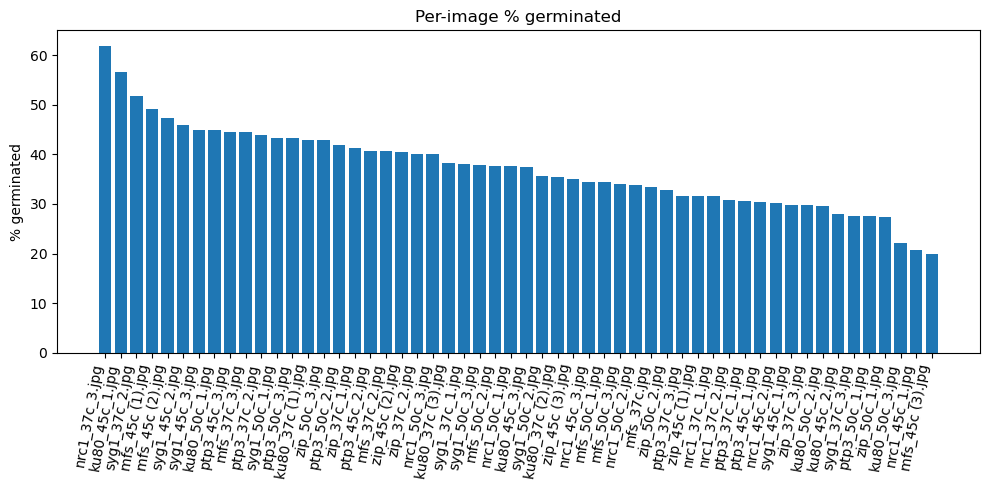

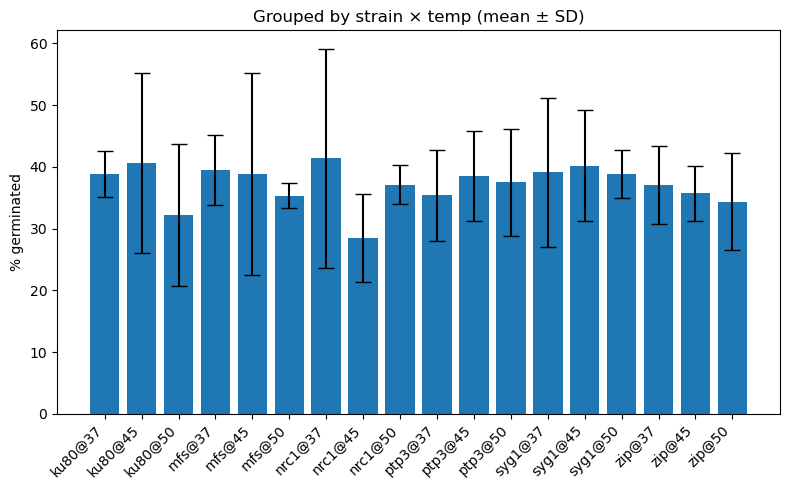

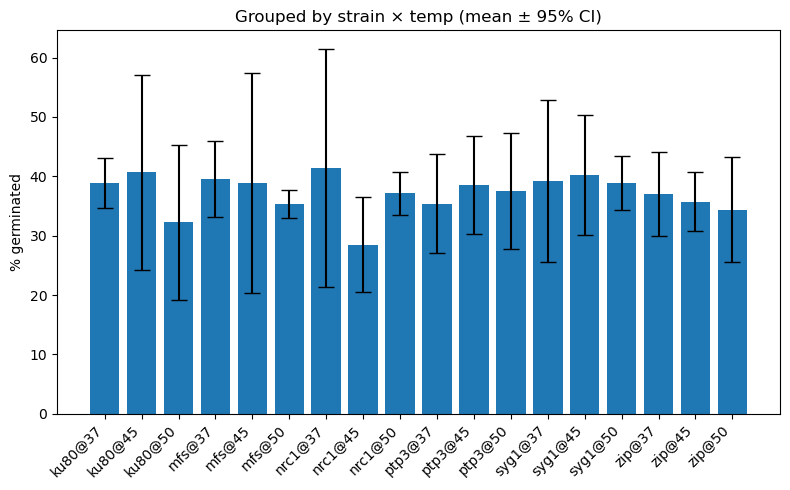

,strain,temp,mean,std,count,sem,ci95
0,ku80,37,38.885021,3.703710,3,2.138338,4.191142
1,ku80,45,40.657350,14.545043,3,8.397585,16.459266
2,ku80,50,32.226479,11.524250,3,6.653529,13.040917
3,mfs,37,39.479039,5.648808,3,3.261341,6.392228
4,mfs,45,38.858257,16.357563,3,9.444044,18.510326
5,mfs,50,35.339475,2.038432,3,1.176889,2.306703
6,nrc1,37,41.392260,17.769869,3,10.259439,20.108500
7,nrc1,45,28.470421,7.073780,3,4.084049,8.004736
8,nrc1,50,37.131492,3.170157,3,1.830291,3.587371
9,ptp3,37,35.380388,7.401817,3,4.273441,8.375945


In [2]:
# === Batch Fungal Germination Counter (Jupyter version) ======================
# Adds: mean±SD/SEM/95% CI per strain×temp + error-bar plots + replicate parsing

import os, glob, re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from skimage import io, color, filters, morphology, measure, exposure, segmentation, feature, util
from scipy import ndimage as ndi

# ----------------------- USER SETTINGS ---------------------------------------
image_folder = "/usr2/people/shollyt22/shollyt22/TnSeq_BarSeq_sequencings/plate_germination_assays/09_24_25"
input_glob = os.path.join(image_folder, "*.jpg")
meta_regex = r"(?P<strain>ku80|mfs|zip|syg1|nrc1|ptp3)_(?P<temp>\d+)"  # include all 6 strains
save_overlays_next_to_images = True
output_prefix = os.path.join(image_folder, "germination_measurements_all")

# Segmentation & classification thresholds (tune if needed)
MIN_AREA = 25
MAX_AREA = 10000
ASPECT_THRESHOLD = 2.0           # stricter
SKELETON_DIAM_RATIO = 1.8        # stricter
SAUVOLA_WINDOW = 61
SAUVOLA_K = 0.2
GAUSSIAN_SIGMA = 1.0
OPENING_RADIUS = 1
HOLE_AREA = 64
WATERSHED_SPLIT = True
PEAK_FOOTPRINT = 15
# -----------------------------------------------------------------------------

# ----------------------- CORE FUNCTIONS --------------------------------------
def parse_meta(filename, meta_regex=None):
    """Parse strain, temp, and replicate from filename."""
    base = os.path.basename(filename)
    info = {"strain": None, "temp": None, "replicate": None}

    # Regex with named groups (recommended)
    if meta_regex:
        m = re.search(meta_regex, base, flags=re.IGNORECASE)
        if m:
            info["strain"] = m.groupdict().get("strain")
            info["temp"]   = m.groupdict().get("temp")

    # Fallback heuristics (if regex not provided or didn’t match)
    s = base.lower()
    if info["strain"] is None:
        for key in ["ku80", "mfs", "zip", "wt", "ptp3", "syg1", "nrc1"]:
            if key in s:
                info["strain"] = key
                break
    if info["temp"] is None:
        mt = re.search(r"(?:^|_|-)(\d{2})(?:c|deg|$|_|-)", s)
        if mt:
            info["temp"] = mt.group(1)

    # Replicate like " (3).jpg"
    mr = re.search(r"\((\d+)\)", base)
    if mr:
        info["replicate"] = int(mr.group(1))
    return info

def analyze_image(path):
    """Return (DataFrame, overlay_array) for a single image."""
    img = io.imread(path)
    gray = color.rgb2gray(img) if img.ndim == 3 else img.astype(float)
    gray = util.img_as_float(gray)

    # Enhance & invert (helps for phase-contrast)
    g = exposure.equalize_adapthist(gray, clip_limit=0.01)
    inv = 1.0 - g
    blur = filters.gaussian(inv, sigma=GAUSSIAN_SIGMA)

    # Adaptive threshold + cleanup
    th = filters.threshold_sauvola(blur, window_size=SAUVOLA_WINDOW, k=SAUVOLA_K)
    bw = blur > th
    bw = morphology.remove_small_holes(bw, area_threshold=HOLE_AREA)
    bw = morphology.remove_small_objects(bw, MIN_AREA)
    bw = morphology.binary_opening(bw, morphology.disk(OPENING_RADIUS))

    # Optional: split touching objects
    if WATERSHED_SPLIT:
        dist = ndi.distance_transform_edt(bw)
        coords = feature.peak_local_max(
            dist, footprint=np.ones((PEAK_FOOTPRINT, PEAK_FOOTPRINT)), labels=bw, exclude_border=False
        )
        seeds = np.zeros_like(dist, dtype=bool)
        if coords.size:
            seeds[tuple(coords.T)] = True
        markers = measure.label(seeds)
        labels = segmentation.watershed(-dist, markers, mask=bw)
    else:
        labels = measure.label(bw)

    props = measure.regionprops(labels)
    rows = []
    overlay = color.gray2rgb((g * 255).astype(np.uint8))

    for p in props:
        if p.area < MIN_AREA or p.area > MAX_AREA:
            continue

        maj = max(p.major_axis_length, 1.0)
        minr = max(p.minor_axis_length, 1.0)
        aspect = maj / minr
        equiv  = p.equivalent_diameter

        skel = morphology.skeletonize(labels == p.label)
        sklen = int(np.count_nonzero(skel))

        # Classification rule (OR)
        is_germ = (aspect >= ASPECT_THRESHOLD) or (sklen >= SKELETON_DIAM_RATIO * equiv)

        rows.append({
            "file": os.path.basename(path),
            "label": int(p.label),
            "area_px": int(p.area),
            "major_axis_px": float(maj),
            "minor_axis_px": float(minr),
            "aspect_ratio": float(aspect),
            "equiv_diameter_px": float(equiv),
            "skeleton_len_px": int(sklen),
            "is_germinated": int(is_germ),
        })

        rr, cc = p.coords[:, 0], p.coords[:, 1]
        overlay[rr, cc] = [0, 255, 0] if is_germ else [255, 0, 0]

    return pd.DataFrame(rows), overlay
# -----------------------------------------------------------------------------

# ----------------------- RUN BATCH -------------------------------------------
paths = [p for p in glob.glob(input_glob)
         if os.path.splitext(p)[1].lower() in {".png", ".jpg", ".jpeg", ".tif", ".tiff"}]
assert len(paths) > 0, f"No images found at: {input_glob}"

all_rows = []
meta_rows = []
for p in sorted(paths):
    df, overlay = analyze_image(p)
    meta = parse_meta(p, meta_regex)

    if meta["strain"] is not None: df["strain"] = meta["strain"]
    if meta["temp"]   is not None: df["temp"]   = meta["temp"]
    if meta["replicate"] is not None: df["replicate"] = meta["replicate"]

    all_rows.append(df)

    # Save overlays
    out_png = (os.path.splitext(p)[0] + "_overlay.png") if save_overlays_next_to_images \
              else os.path.join(image_folder, os.path.basename(os.path.splitext(p)[0]) + "_overlay.png")
    io.imsave(out_png, overlay)

    print(f"{os.path.basename(p)} -> N={len(df)}  germinated={int(df.is_germinated.sum())}  overlay={os.path.basename(out_png)}")

# Per-object table
big = pd.concat(all_rows, ignore_index=True)
big.to_csv(f"{output_prefix}.csv", index=False)
print("Saved per-object measurements:", f"{output_prefix}.csv")

# ----------------------- SUMMARIES -------------------------------------------
# Per-image summary (% germinated)
per_file = big.groupby("file").agg(
    total=("is_germinated","count"),
    germinated=("is_germinated","sum")
).reset_index()
per_file["percent_germinated"] = 100 * per_file["germinated"] / per_file["total"].clip(lower=1)
per_file.to_csv(f"{output_prefix}_perfile.csv", index=False)
print("Saved per-image summary:", f"{output_prefix}_perfile.csv")

# Compute per-image % then aggregate by strain×temp to get mean/SD/SEM/CI
per_file_with_meta = per_file.merge(
    big[["file","strain","temp"]].drop_duplicates(), on="file", how="left"
)

summary = (
    per_file_with_meta
    .groupby(["strain","temp"])["percent_germinated"]
    .agg(["mean","std","count"])
    .reset_index()
)
summary["sem"] = summary["std"] / np.sqrt(summary["count"].clip(lower=1))
summary["ci95"] = 1.96 * summary["sem"]
summary = summary.sort_values(["strain","temp"])
summary.to_csv(f"{output_prefix}_by_strain_temp_stats.csv", index=False)
print("Saved grouped stats (mean, SD, SEM, 95% CI):", f"{output_prefix}_by_strain_temp_stats.csv")

# ----------------------- PLOTS (with error bars) -----------------------------
# Per-image (no error bars; each is a single estimate)
plt.figure(figsize=(10, 5))
order = per_file.sort_values("percent_germinated", ascending=False)
plt.bar(order["file"], order["percent_germinated"])
plt.xticks(rotation=80, ha="right")
plt.ylabel("% germinated")
plt.title("Per-image % germinated")
plt.tight_layout()
plt.show()

# Grouped mean ± SD
plt.figure(figsize=(8, 5))
labels = [f"{r.strain}@{r.temp}" for r in summary.itertuples()]
plt.bar(labels, summary["mean"], yerr=summary["std"], capsize=6)
plt.xticks(rotation=45, ha="right")
plt.ylabel("% germinated")
plt.title("Grouped by strain × temp (mean ± SD)")
plt.tight_layout()
plt.show()

# Grouped mean ± 95% CI (often nicer to compare means)
plt.figure(figsize=(8, 5))
plt.bar(labels, summary["mean"], yerr=summary["ci95"], capsize=6)
plt.xticks(rotation=45, ha="right")
plt.ylabel("% germinated")
plt.title("Grouped by strain × temp (mean ± 95% CI)")
plt.tight_layout()
plt.show()

# Peek
summary.head(10)


## Raw % germination heatmap (means across replicates)

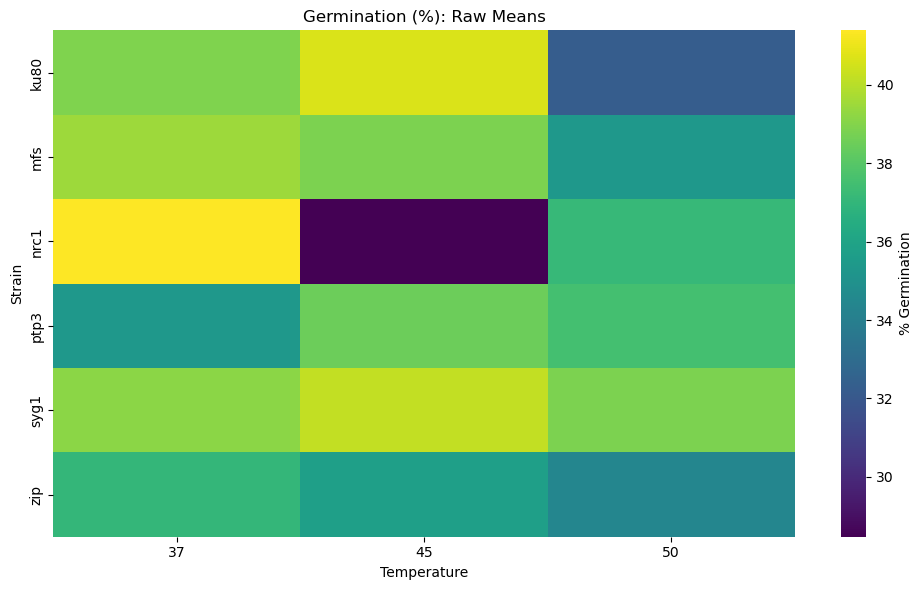

In [5]:
# ==== RAW % GERMINATION HEATMAP (robust column detection) ====================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re

# ---- Config ----
FILE = "/usr2/people/shollyt22/shollyt22/TnSeq_BarSeq_sequencings/plate_germination_assays/09_24_25/germination_measurements_all_temp_perfile.csv"

# ---- Helpers ----
def find_col(df, candidates, required=True, purpose=""):
    """Find first matching column in candidates (case-insensitive)."""
    lower_map = {c.lower(): c for c in df.columns}
    for cand in candidates:
        if cand.lower() in lower_map:
            return lower_map[cand.lower()]
    if required:
        raise KeyError(f"Could not find a column for {purpose or candidates}.\n"
                       f"Available columns: {list(df.columns)}")
    return None

def to_num_temp(x):
    """Extract numeric part of temperature like '45C' -> 45.0."""
    m = re.search(r"-?\d+\.?\d*", str(x))
    return float(m.group()) if m else np.nan

# ---- Load ----
df = pd.read_csv(FILE)

# ---- Identify columns (case-insensitive, with synonyms) ----
strain_col = find_col(
    df, ["Strain", "strain", "Mutant", "mutant", "Genotype", "genotype"],
    purpose="strain"
)
temp_col = find_col(
    df, ["Temperature", "temperature", "Temp", "temp", "Temp_C", "temp_C"],
    purpose="temperature"
)

# Prefer a pre-computed percent column; otherwise compute from germinated/total
percent_col = find_col(
    df, ["percent_germinated", "Percent_Germinated", "%Germination", "Germination", "germination"],
    required=False
)
if percent_col is None:
    germ_col = find_col(df, ["germinated", "Germinated"], purpose="germinated count")
    total_col = find_col(df, ["total", "Total", "count", "Count"], purpose="total count")
    # Compute % germination safely
    df["_PercentGerm"] = (df[germ_col].astype(float) / df[total_col].replace(0, np.nan).astype(float)) * 100
    value_col = "_PercentGerm"
else:
    # Coerce to numeric in case it's a string with % signs
    df["_PercentGerm"] = (
        pd.to_numeric(df[percent_col].astype(str).str.replace("%","", regex=False), errors="coerce")
    )
    value_col = "_PercentGerm"

# ---- Clean and order temperatures numerically ----
df["_TempNum"] = df[temp_col].apply(to_num_temp)
# Build label order preserving the original text associated with sorted numeric temps
temp_labels = (
    df[[temp_col, "_TempNum"]]
    .drop_duplicates()
    .sort_values("_TempNum")[temp_col]
    .tolist()
)

# ---- Pivot (mean across replicates) ----
heat = df.pivot_table(
    index=strain_col,
    columns=temp_col,
    values=value_col,
    aggfunc="mean"
)[temp_labels]  # enforce numeric order

# ---- Plot ----
plt.figure(figsize=(10, 6))
ax = sns.heatmap(
    heat, cmap="viridis", annot=False, fmt=".1f",
    cbar_kws={"label": "% Germination"}
)
ax.set_title("Germination (%): Raw Means")
ax.set_xlabel("Temperature")
ax.set_ylabel("Strain")
plt.tight_layout()
plt.show()


### Z-score heatmap (row-wise: per strain across temperatures)

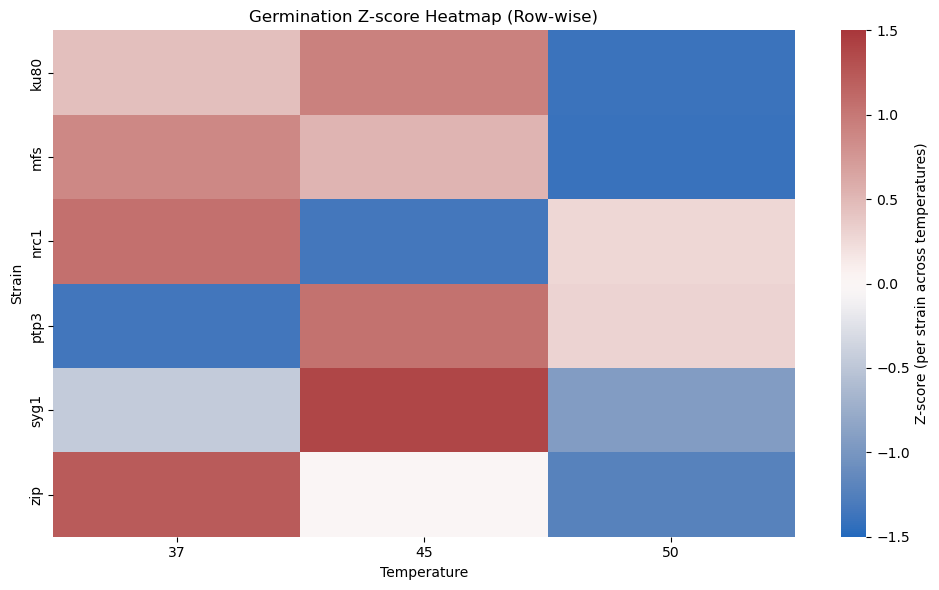

In [6]:
# ==== Z-SCORE HEATMAP (ROW-WISE: PER STRAIN across temperatures) =============
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re

# ---- Config ----
FILE = "/usr2/people/shollyt22/shollyt22/TnSeq_BarSeq_sequencings/plate_germination_assays/09_24_25/germination_measurements_all_temp_perfile.csv"

# ---- Helpers ----
def find_col(df, candidates, required=True, purpose=""):
    """Find first matching column in candidates (case-insensitive)."""
    lower_map = {c.lower(): c for c in df.columns}
    for cand in candidates:
        if cand.lower() in lower_map:
            return lower_map[cand.lower()]
    if required:
        raise KeyError(f"Could not find a column for {purpose or candidates}.\n"
                       f"Available columns: {list(df.columns)}")
    return None

def to_num_temp(x):
    """Extract numeric part of temperature like '45C' -> 45.0."""
    m = re.search(r"-?\d+\.?\d*", str(x))
    return float(m.group()) if m else np.nan

# ---- Load ----
df = pd.read_csv(FILE)

# ---- Identify columns (case-insensitive, with synonyms) ----
strain_col = find_col(df, ["Strain","strain","Mutant","mutant","Genotype","genotype"], purpose="strain")
temp_col   = find_col(df, ["Temperature","temperature","Temp","temp","Temp_C","temp_C"], purpose="temperature")

# Prefer a pre-computed percent column; otherwise compute from germinated/total
percent_col = find_col(df, ["percent_germinated","Percent_Germinated","%Germination","Germination","germination"],
                       required=False)
if percent_col is None:
    germ_col  = find_col(df, ["germinated","Germinated"], purpose="germinated count")
    total_col = find_col(df, ["total","Total","count","Count"], purpose="total count")
    df["_PercentGerm"] = (df[germ_col].astype(float) / df[total_col].replace(0, np.nan).astype(float)) * 100
    value_col = "_PercentGerm"
else:
    df["_PercentGerm"] = pd.to_numeric(df[percent_col].astype(str).str.replace("%","", regex=False), errors="coerce")
    value_col = "_PercentGerm"

# ---- Clean and order temperatures numerically ----
df["_TempNum"] = df[temp_col].apply(to_num_temp)
temp_labels = (
    df[[temp_col, "_TempNum"]]
    .drop_duplicates()
    .sort_values("_TempNum")[temp_col]
    .tolist()
)

# ---- Pivot to mean % germination per (strain, temp) ----
mat = df.pivot_table(
    index=strain_col,
    columns=temp_col,
    values=value_col,
    aggfunc="mean"
)[temp_labels]

# ---- Row-wise Z-scores: (x - row_mean) / row_std ----
row_means = mat.mean(axis=1)
row_stds  = mat.std(axis=1, ddof=0)  # population std; use ddof=1 if you prefer sample std
z = (mat.sub(row_means, axis=0)).div(row_stds.replace(0, np.nan), axis=0)

# Optional: choose symmetric color limits based on data spread (nice for visuals)
abs_max = np.nanmax(np.abs(z.values))
if np.isfinite(abs_max):
    vmax = max(1.5, abs_max)   # at least ±1.5
else:
    vmax = 2
vmin = -vmax

# ---- Plot ----
plt.figure(figsize=(10, 6))
ax = sns.heatmap(
    z,
    cmap="vlag",          # diverging; zero centered
    center=0,
    vmin=vmin, vmax=vmax,
    annot=False,          # no numbers in cells
    cbar_kws={"label": "Z-score (per strain across temperatures)"}
)
ax.set_title("Germination Z-score Heatmap (Row-wise)")
ax.set_xlabel("Temperature")
ax.set_ylabel("Strain")
plt.tight_layout()
plt.show()


### Normalize each mutant by ku80 at the same temperature (mutant/ku80)

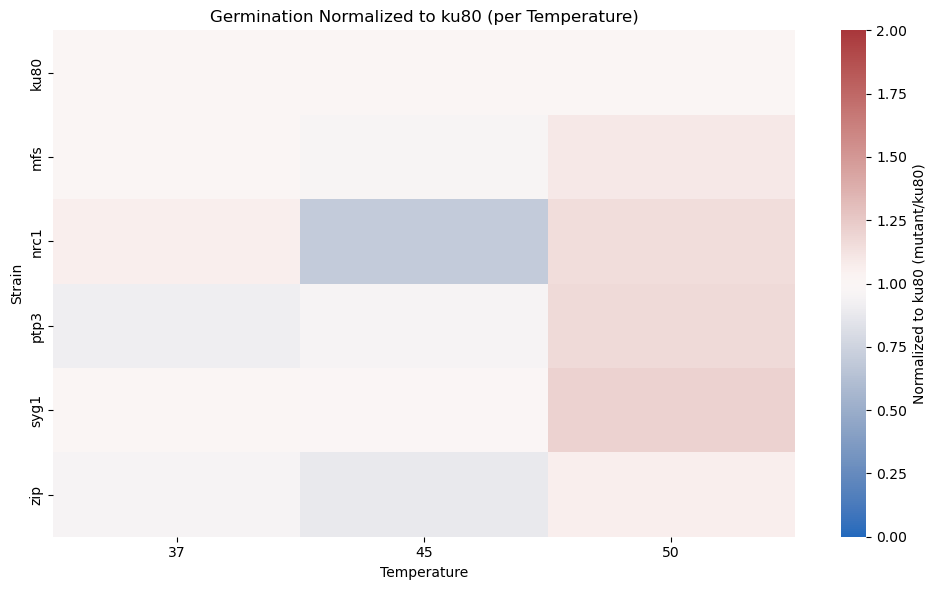

In [7]:
# ==== NORMALIZED BY KU80 (PER TEMPERATURE) ===================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re

# ---- Config ----
FILE = "/usr2/people/shollyt22/shollyt22/TnSeq_BarSeq_sequencings/plate_germination_assays/09_24_25/germination_measurements_all_temp_perfile.csv"
KU80_NAME = "ku80"  # reference strain label (case-insensitive)

# ---- Helpers ----
def find_col(df, candidates, required=True, purpose=""):
    """Find first matching column in candidates (case-insensitive)."""
    lower_map = {c.lower(): c for c in df.columns}
    for cand in candidates:
        if cand.lower() in lower_map:
            return lower_map[cand.lower()]
    if required:
        raise KeyError(f"Could not find a column for {purpose or candidates}.\n"
                       f"Available columns: {list(df.columns)}")
    return None

def to_num_temp(x):
    """Extract numeric part of temperature like '45C' -> 45.0."""
    m = re.search(r"-?\d+\.?\d*", str(x))
    return float(m.group()) if m else np.nan

# ---- Load ----
df = pd.read_csv(FILE)

# ---- Identify columns (case-insensitive) ----
strain_col = find_col(df, ["Strain","strain","Mutant","mutant","Genotype","genotype"], purpose="strain")
temp_col   = find_col(df, ["Temperature","temperature","Temp","temp","Temp_C","temp_C"], purpose="temperature")

# Prefer a pre-computed percent column; otherwise compute from germinated/total
percent_col = find_col(df, ["percent_germinated","Percent_Germinated","%Germination","Germination","germination"],
                       required=False)
if percent_col is None:
    germ_col = find_col(df, ["germinated","Germinated"], purpose="germinated count")
    total_col = find_col(df, ["total","Total","count","Count"], purpose="total count")
    df["_PercentGerm"] = (df[germ_col].astype(float) / df[total_col].replace(0, np.nan).astype(float)) * 100
    value_col = "_PercentGerm"
else:
    df["_PercentGerm"] = (
        pd.to_numeric(df[percent_col].astype(str).str.replace("%","", regex=False), errors="coerce")
    )
    value_col = "_PercentGerm"

# ---- Clean and order temperatures numerically ----
df["_TempNum"] = df[temp_col].apply(to_num_temp)
temp_labels = (
    df[[temp_col, "_TempNum"]]
    .drop_duplicates()
    .sort_values("_TempNum")[temp_col]
    .tolist()
)

# ---- Compute mean per (strain, temp) ----
means = (
    df.groupby([strain_col, temp_col], as_index=False)[value_col]
      .mean()
      .rename(columns={value_col: "MeanVal"})
)

# ---- Extract ku80 per temp and merge ----
is_ku80 = means[strain_col].str.strip().str.lower() == KU80_NAME.lower()
ref = means[is_ku80]
if ref.empty:
    raise ValueError(f"Reference strain '{KU80_NAME}' not found in column '{strain_col}'.")

ref = ref[[temp_col, "MeanVal"]].rename(columns={"MeanVal": "RefVal"})
norm = means.merge(ref, on=temp_col, how="left")

# Normalize each mutant by ku80 at that temperature
norm["NormVal"] = norm["MeanVal"] / norm["RefVal"].replace(0, np.nan)

# ---- Pivot ----
heat = norm.pivot_table(
    index=strain_col,
    columns=temp_col,
    values="NormVal",
    aggfunc="mean"
)[temp_labels]

# ---- Plot ----
label = f"Normalized to {KU80_NAME} (mutant/{KU80_NAME})"

plt.figure(figsize=(10, 6))
ax = sns.heatmap(
    heat,
    cmap="vlag",         # diverging colormap is clearer for fold-changes
    center=1,            # center the color scale on 1 (reference level)
    annot=False,         # no numbers in cells
    cbar_kws={"label": label},
    vmin=0,
    vmax=max(2, np.nanmax(heat.values))  # adjust if needed
)
ax.set_title(f"Germination Normalized to {KU80_NAME} (per Temperature)")
ax.set_xlabel("Temperature")
ax.set_ylabel("Strain")
plt.tight_layout()
plt.show()


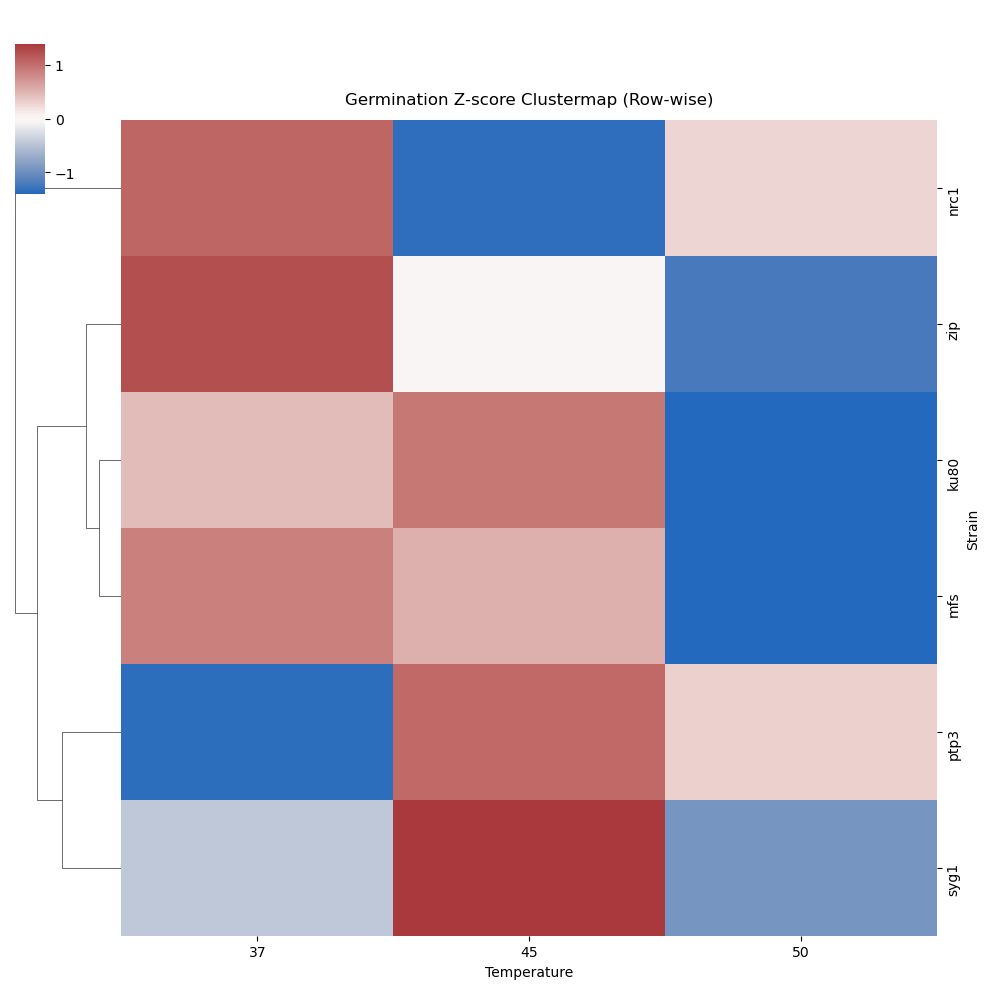

In [8]:
# ==== CLUSTERMAP: ROW-WISE Z-SCORES (cluster rows, keep temp order) ==========
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re

# ---- Config ----
FILE = "/usr2/people/shollyt22/shollyt22/TnSeq_BarSeq_sequencings/plate_germination_assays/09_24_25/germination_measurements_all_temp_perfile.csv"
ROW_METRIC = "euclidean"   # e.g., "euclidean", "correlation", "cosine"
ROW_METHOD = "average"     # e.g., "average", "complete", "single", "ward"
COL_CLUSTER = False        # keep numeric temp order (False) or cluster columns (True)

# ---- Helpers ----
def find_col(df, candidates, required=True, purpose=""):
    lower_map = {c.lower(): c for c in df.columns}
    for cand in candidates:
        if cand.lower() in lower_map:
            return lower_map[cand.lower()]
    if required:
        raise KeyError(f"Could not find a column for {purpose or candidates}. "
                       f"Available: {list(df.columns)}")
    return None

def to_num_temp(x):
    m = re.search(r"-?\d+\.?\d*", str(x))
    return float(m.group()) if m else np.nan

# ---- Load & identify columns ----
df = pd.read_csv(FILE)
strain_col = find_col(df, ["Strain","strain","Mutant","mutant","Genotype","genotype"], purpose="strain")
temp_col   = find_col(df, ["Temperature","temperature","Temp","temp","Temp_C","temp_C"], purpose="temperature")
pct_col    = find_col(df, ["percent_germinated","Percent_Germinated","%Germination","Germination","germination"], required=False)

# Build % germination if needed
if pct_col is None:
    germ_col  = find_col(df, ["germinated","Germinated"], purpose="germinated count")
    total_col = find_col(df, ["total","Total","count","Count"], purpose="total count")
    df["_PercentGerm"] = (df[germ_col].astype(float) / df[total_col].replace(0, np.nan).astype(float)) * 100
    val_col = "_PercentGerm"
else:
    df["_PercentGerm"] = pd.to_numeric(df[pct_col].astype(str).str.replace("%","", regex=False), errors="coerce")
    val_col = "_PercentGerm"

# ---- Temperature order ----
df["_TempNum"] = df[temp_col].apply(to_num_temp)
temp_labels = (
    df[[temp_col, "_TempNum"]].drop_duplicates().sort_values("_TempNum")[temp_col].tolist()
)

# ---- Pivot to means ----
mat = df.pivot_table(index=strain_col, columns=temp_col, values=val_col, aggfunc="mean")[temp_labels]

# ---- Row-wise Z-score ----
row_means = mat.mean(axis=1)
row_stds  = mat.std(axis=1, ddof=0)
z = (mat.sub(row_means, axis=0)).div(row_stds.replace(0, np.nan), axis=0)

# ---- Clustermap ----
# If keeping temp order, pass col_cluster=False so columns are not re-ordered.
g = sns.clustermap(
    z,
    cmap="vlag", center=0,
    metric=ROW_METRIC, method=ROW_METHOD,
    row_cluster=True, col_cluster=COL_CLUSTER,
    dendrogram_ratio=0.12, cbar_pos=(0.02, 0.8, 0.03, 0.15),  # tweak as you like
    linewidths=0, xticklabels=True, yticklabels=True
)
g.ax_heatmap.set_xlabel("Temperature")
g.ax_heatmap.set_ylabel("Strain")
g.ax_heatmap.set_title("Germination Z-score Clustermap (Row-wise)", pad=12)
plt.show()


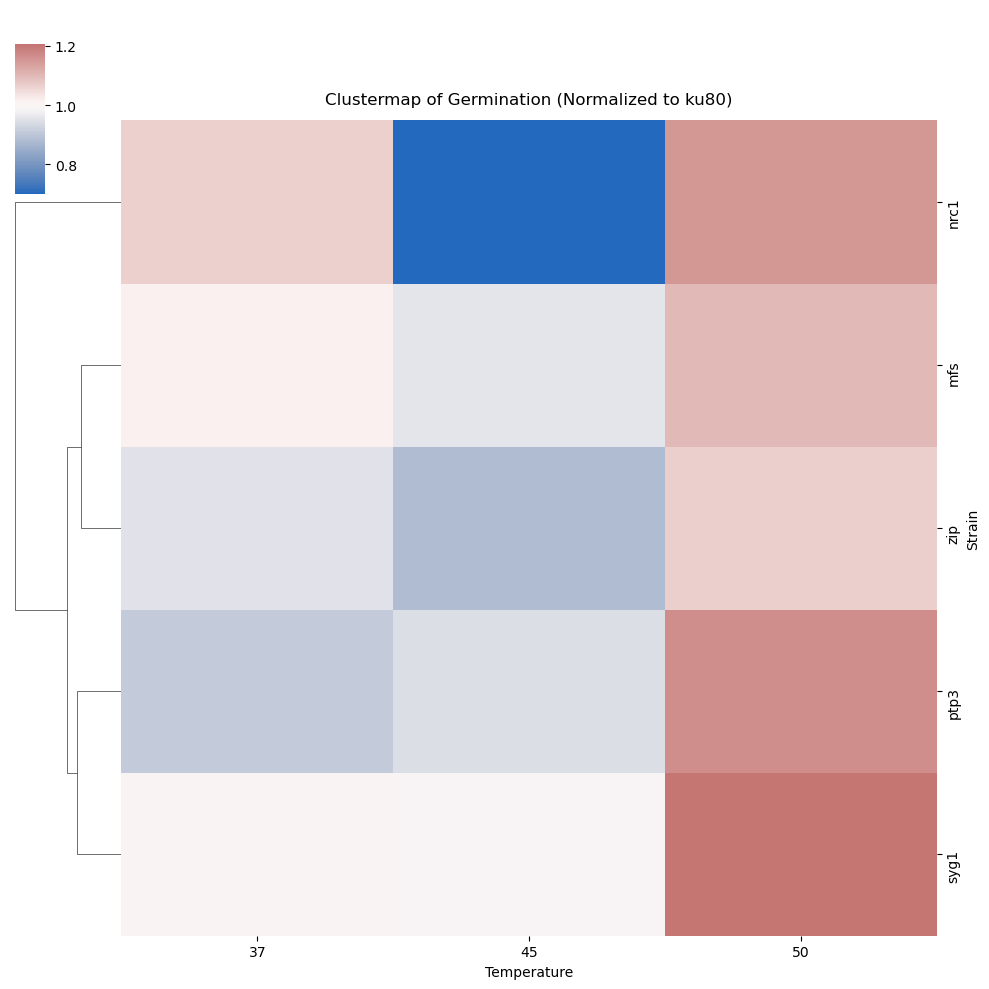

In [9]:
# ==== CLUSTERMAP: KU80-NORMALIZED (exclude ku80 itself) ======================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re

# ---- Config ----
FILE = "/usr2/people/shollyt22/shollyt22/TnSeq_BarSeq_sequencings/plate_germination_assays/09_24_25/germination_measurements_all_temp_perfile.csv"
KU80_NAME = "ku80"         # case-insensitive
ROW_METRIC = "euclidean"
ROW_METHOD = "average"
COL_CLUSTER = False        # keep numeric temp order

# ---- Helpers ----
def find_col(df, candidates, required=True, purpose=""):
    lower_map = {c.lower(): c for c in df.columns}
    for cand in candidates:
        if cand.lower() in lower_map:
            return lower_map[cand.lower()]
    if required:
        raise KeyError(f"Could not find a column for {purpose or candidates}. "
                       f"Available: {list(df.columns)}")
    return None

def to_num_temp(x):
    m = re.search(r"-?\d+\.?\d*", str(x))
    return float(m.group()) if m else np.nan

# ---- Load & identify columns ----
df = pd.read_csv(FILE)
strain_col = find_col(df, ["Strain","strain","Mutant","mutant","Genotype","genotype"], purpose="strain")
temp_col   = find_col(df, ["Temperature","temperature","Temp","temp","Temp_C","temp_C"], purpose="temperature")
pct_col    = find_col(df, ["percent_germinated","Percent_Germinated","%Germination","Germination","germination"], required=False)

# Build % germination if needed
if pct_col is None:
    germ_col  = find_col(df, ["germinated","Germinated"], purpose="germinated count")
    total_col = find_col(df, ["total","Total","count","Count"], purpose="total count")
    df["_PercentGerm"] = (df[germ_col].astype(float) / df[total_col].replace(0, np.nan).astype(float)) * 100
    val_col = "_PercentGerm"
else:
    df["_PercentGerm"] = pd.to_numeric(df[pct_col].astype(str).str.replace("%","", regex=False), errors="coerce")
    val_col = "_PercentGerm"

# ---- Temperature order ----
df["_TempNum"] = df[temp_col].apply(to_num_temp)
temp_labels = (
    df[[temp_col, "_TempNum"]].drop_duplicates().sort_values("_TempNum")[temp_col].tolist()
)

# ---- Mean per (strain, temp) ----
means = (
    df.groupby([strain_col, temp_col], as_index=False)[val_col]
      .mean().rename(columns={val_col: "MeanVal"})
)

# ---- Normalize to ku80 at each temperature ----
is_ku80 = means[strain_col].str.strip().str.lower() == KU80_NAME.lower()
ref = means[is_ku80]
if ref.empty:
    raise ValueError(f"Reference strain '{KU80_NAME}' not found in '{strain_col}'.")
ref = ref[[temp_col, "MeanVal"]].rename(columns={"MeanVal": "RefVal"})
norm = means.merge(ref, on=temp_col, how="left")
norm["NormVal"] = norm["MeanVal"] / norm["RefVal"].replace(0, np.nan)

# ---- Pivot to matrix (exclude ku80 itself) ----
heat = norm.pivot_table(
    index=strain_col,
    columns=temp_col,
    values="NormVal",
    aggfunc="mean"
)[temp_labels]

# Drop the ku80 row (case-insensitive)
mask = heat.index.str.strip().str.lower() != KU80_NAME.lower()
heat = heat[mask]

# ---- Clustermap ----
g = sns.clustermap(
    heat, cmap="vlag", center=1,
    metric=ROW_METRIC, method=ROW_METHOD,
    row_cluster=True, col_cluster=COL_CLUSTER,
    dendrogram_ratio=0.12, cbar_pos=(0.02, 0.8, 0.03, 0.15),
    linewidths=0, xticklabels=True, yticklabels=True
)
g.ax_heatmap.set_xlabel("Temperature")
g.ax_heatmap.set_ylabel("Strain")
g.ax_heatmap.set_title(f"Clustermap of Germination (Normalized to {KU80_NAME})", pad=12)
plt.show()



# combining the three germination batches

#### Clustermap on row-wise Z-scores (cluster rows, keep temp order)

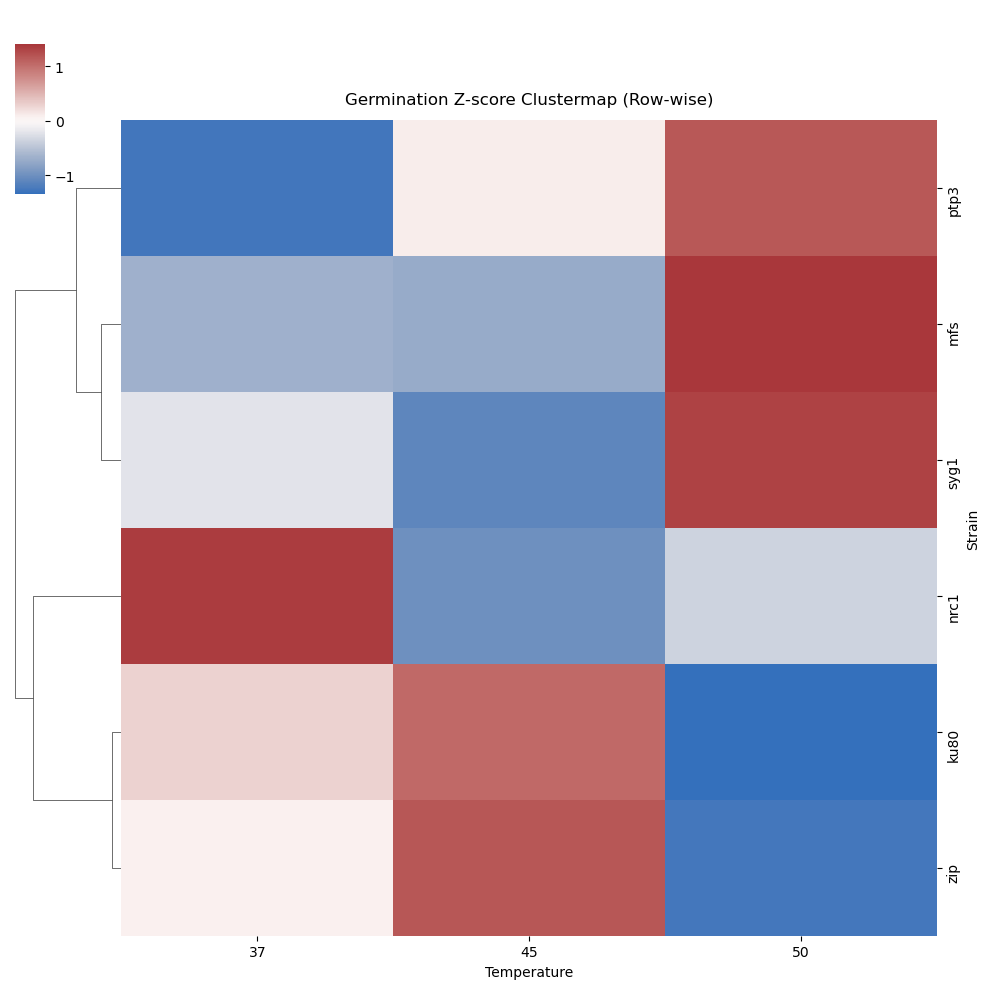

In [10]:
# ==== CLUSTERMAP: ROW-WISE Z-SCORES (cluster rows, keep temp order) ==========
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re

# ---- Config ----
FILE = "/usr2/people/shollyt22/shollyt22/TnSeq_BarSeq_sequencings/plate_germination_assays/09_24_25/germination_measurements_all_temp_perfile-3_reps_combined.csv"
ROW_METRIC = "euclidean"   # e.g., "euclidean", "correlation", "cosine"
ROW_METHOD = "average"     # e.g., "average", "complete", "single", "ward"
COL_CLUSTER = False        # keep numeric temp order (False) or cluster columns (True)

# ---- Helpers ----
def find_col(df, candidates, required=True, purpose=""):
    lower_map = {c.lower(): c for c in df.columns}
    for cand in candidates:
        if cand.lower() in lower_map:
            return lower_map[cand.lower()]
    if required:
        raise KeyError(f"Could not find a column for {purpose or candidates}. "
                       f"Available: {list(df.columns)}")
    return None

def to_num_temp(x):
    m = re.search(r"-?\d+\.?\d*", str(x))
    return float(m.group()) if m else np.nan

# ---- Load & identify columns ----
df = pd.read_csv(FILE)
strain_col = find_col(df, ["Strain","strain","Mutant","mutant","Genotype","genotype"], purpose="strain")
temp_col   = find_col(df, ["Temperature","temperature","Temp","temp","Temp_C","temp_C"], purpose="temperature")
pct_col    = find_col(df, ["percent_germinated","Percent_Germinated","%Germination","Germination","germination"], required=False)

# Build % germination if needed
if pct_col is None:
    germ_col  = find_col(df, ["germinated","Germinated"], purpose="germinated count")
    total_col = find_col(df, ["total","Total","count","Count"], purpose="total count")
    df["_PercentGerm"] = (df[germ_col].astype(float) / df[total_col].replace(0, np.nan).astype(float)) * 100
    val_col = "_PercentGerm"
else:
    df["_PercentGerm"] = pd.to_numeric(df[pct_col].astype(str).str.replace("%","", regex=False), errors="coerce")
    val_col = "_PercentGerm"

# ---- Temperature order ----
df["_TempNum"] = df[temp_col].apply(to_num_temp)
temp_labels = (
    df[[temp_col, "_TempNum"]].drop_duplicates().sort_values("_TempNum")[temp_col].tolist()
)

# ---- Pivot to means ----
mat = df.pivot_table(index=strain_col, columns=temp_col, values=val_col, aggfunc="mean")[temp_labels]

# ---- Row-wise Z-score ----
row_means = mat.mean(axis=1)
row_stds  = mat.std(axis=1, ddof=0)
z = (mat.sub(row_means, axis=0)).div(row_stds.replace(0, np.nan), axis=0)

# ---- Clustermap ----
# If keeping temp order, pass col_cluster=False so columns are not re-ordered.
g = sns.clustermap(
    z,
    cmap="vlag", center=0,
    metric=ROW_METRIC, method=ROW_METHOD,
    row_cluster=True, col_cluster=COL_CLUSTER,
    dendrogram_ratio=0.12, cbar_pos=(0.02, 0.8, 0.03, 0.15),  # tweak as you like
    linewidths=0, xticklabels=True, yticklabels=True
)
g.ax_heatmap.set_xlabel("Temperature")
g.ax_heatmap.set_ylabel("Strain")
g.ax_heatmap.set_title("Germination Z-score Clustermap (Row-wise)", pad=12)
plt.show()


#### Clustermap on ku80-normalized values (mutant/ku80 per temp)

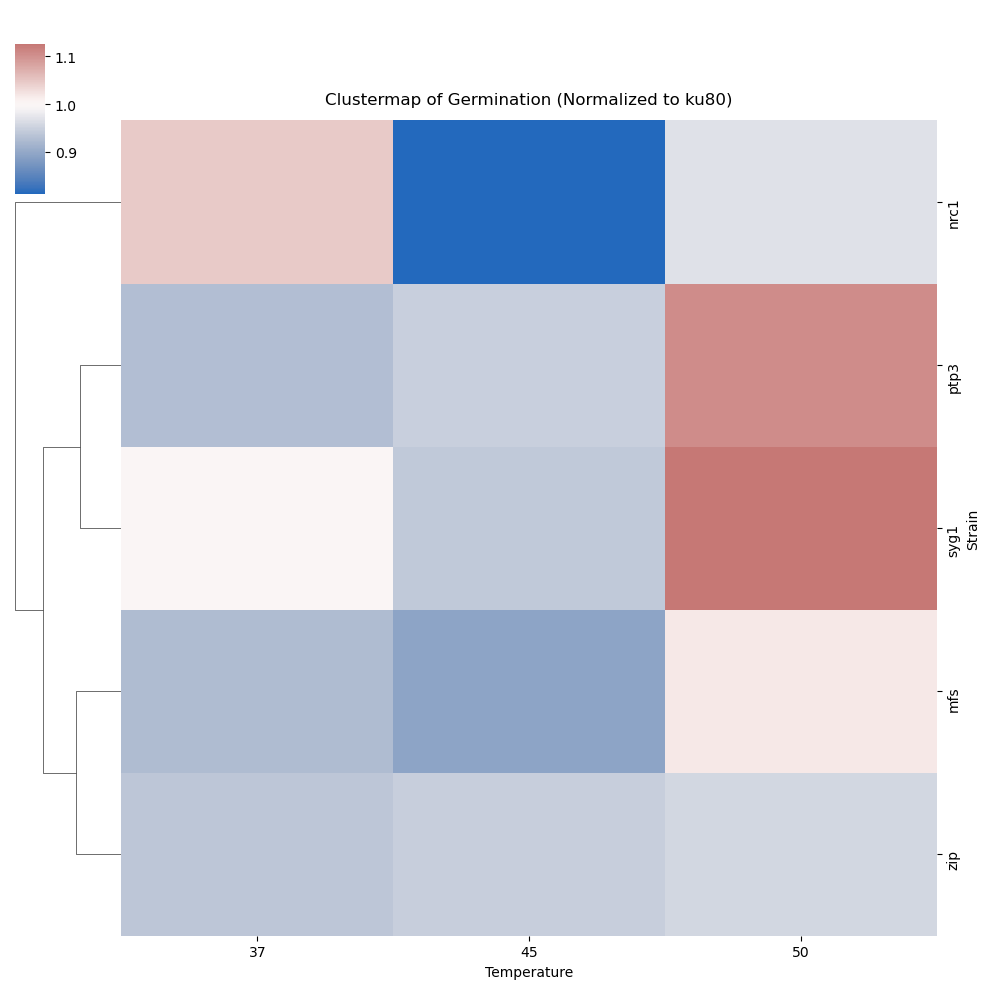

In [11]:
# ==== CLUSTERMAP: KU80-NORMALIZED (exclude ku80 itself) ======================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re

# ---- Config ----
FILE = "/usr2/people/shollyt22/shollyt22/TnSeq_BarSeq_sequencings/plate_germination_assays/09_24_25/germination_measurements_all_temp_perfile-3_reps_combined.csv"
KU80_NAME = "ku80"         # case-insensitive
ROW_METRIC = "euclidean"
ROW_METHOD = "average"
COL_CLUSTER = False        # keep numeric temp order

# ---- Helpers ----
def find_col(df, candidates, required=True, purpose=""):
    lower_map = {c.lower(): c for c in df.columns}
    for cand in candidates:
        if cand.lower() in lower_map:
            return lower_map[cand.lower()]
    if required:
        raise KeyError(f"Could not find a column for {purpose or candidates}. "
                       f"Available: {list(df.columns)}")
    return None

def to_num_temp(x):
    m = re.search(r"-?\d+\.?\d*", str(x))
    return float(m.group()) if m else np.nan

# ---- Load & identify columns ----
df = pd.read_csv(FILE)
strain_col = find_col(df, ["Strain","strain","Mutant","mutant","Genotype","genotype"], purpose="strain")
temp_col   = find_col(df, ["Temperature","temperature","Temp","temp","Temp_C","temp_C"], purpose="temperature")
pct_col    = find_col(df, ["percent_germinated","Percent_Germinated","%Germination","Germination","germination"], required=False)

# Build % germination if needed
if pct_col is None:
    germ_col  = find_col(df, ["germinated","Germinated"], purpose="germinated count")
    total_col = find_col(df, ["total","Total","count","Count"], purpose="total count")
    df["_PercentGerm"] = (df[germ_col].astype(float) / df[total_col].replace(0, np.nan).astype(float)) * 100
    val_col = "_PercentGerm"
else:
    df["_PercentGerm"] = pd.to_numeric(df[pct_col].astype(str).str.replace("%","", regex=False), errors="coerce")
    val_col = "_PercentGerm"

# ---- Temperature order ----
df["_TempNum"] = df[temp_col].apply(to_num_temp)
temp_labels = (
    df[[temp_col, "_TempNum"]].drop_duplicates().sort_values("_TempNum")[temp_col].tolist()
)

# ---- Mean per (strain, temp) ----
means = (
    df.groupby([strain_col, temp_col], as_index=False)[val_col]
      .mean().rename(columns={val_col: "MeanVal"})
)

# ---- Normalize to ku80 at each temperature ----
is_ku80 = means[strain_col].str.strip().str.lower() == KU80_NAME.lower()
ref = means[is_ku80]
if ref.empty:
    raise ValueError(f"Reference strain '{KU80_NAME}' not found in '{strain_col}'.")
ref = ref[[temp_col, "MeanVal"]].rename(columns={"MeanVal": "RefVal"})
norm = means.merge(ref, on=temp_col, how="left")
norm["NormVal"] = norm["MeanVal"] / norm["RefVal"].replace(0, np.nan)

# ---- Pivot to matrix (exclude ku80 itself) ----
heat = norm.pivot_table(
    index=strain_col,
    columns=temp_col,
    values="NormVal",
    aggfunc="mean"
)[temp_labels]

# Drop the ku80 row (case-insensitive)
mask = heat.index.str.strip().str.lower() != KU80_NAME.lower()
heat = heat[mask]

# ---- Clustermap ----
g = sns.clustermap(
    heat, cmap="vlag", center=1,
    metric=ROW_METRIC, method=ROW_METHOD,
    row_cluster=True, col_cluster=COL_CLUSTER,
    dendrogram_ratio=0.12, cbar_pos=(0.02, 0.8, 0.03, 0.15),
    linewidths=0, xticklabels=True, yticklabels=True
)
g.ax_heatmap.set_xlabel("Temperature")
g.ax_heatmap.set_ylabel("Strain")
g.ax_heatmap.set_title(f"Clustermap of Germination (Normalized to {KU80_NAME})", pad=12)
plt.show()

